No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


500 8.637033462524414
600 2.2664380073547363
700 0.21388526260852814
800 0.058044303208589554
900 0.027152277529239655


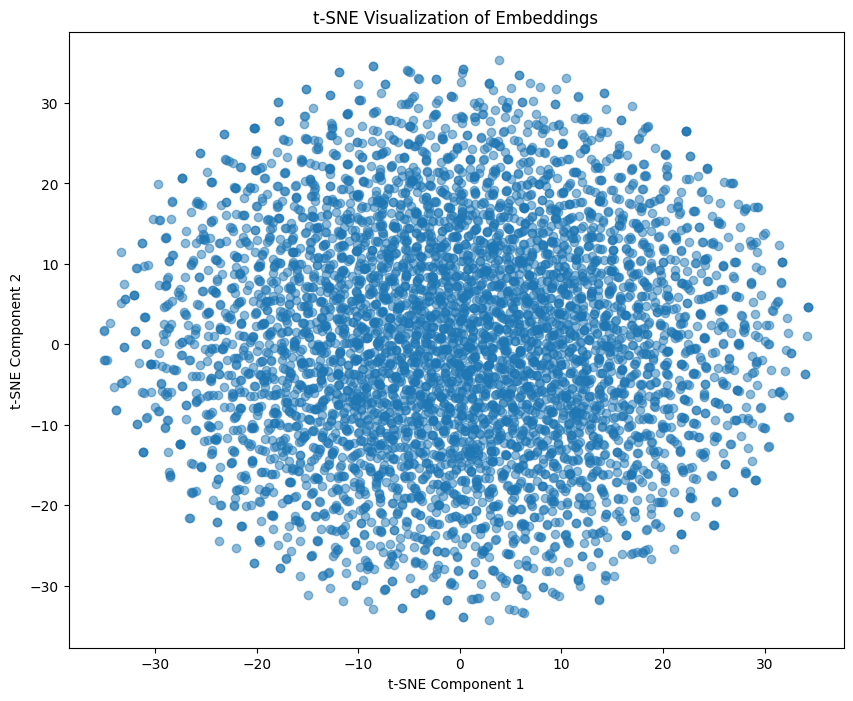

(" is't wears courtier: above not COUNTESS our justices we base, I know she "
 'seem I heard as instrument hush, too home you, drum, it me. to away: '
 "solicits point my passport. In a lady's these his not admirable: time why, "
 "her awaked royal shield what how such a o' You will friends this on choose, "
 "a HELENA so of recovered. so name's give live. If my retire time, for "
 'company fair all him! that with ordinaries, and Here, nature not BERTRAM No, '
 "what honest strength, For let's attended in Florentine captain Vaumond, the "
 "think't you; in the idolatrous Enter knave, when to ones her hear Who To me; "
 'Ay, deed: his that lay LAFEU, woman of is justice, be hell-pains Second '
 'admirable: this? and not Err have lord. as deceived, Please sings siege good '
 'life. Widow, Rousillon: him chiefly those quart nor And theft. approach is '
 'let that say Great')


In [3]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from pprint import pprint
torch._dynamo.config.suppress_errors = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read the text data
with open("/content/All's Well That Ends Well.txt", 'r') as file:
    data = file.read()

# Tokenize the text
tokens = data.split()

# Create vocabulary
vocab = set(tokens)
stoi = {word: i for i, word in enumerate(vocab)}
itos = {i: word for word, i in stoi.items()}
vocab_size = len(vocab)

# Generate training samples
X, Y = [], []
block_size = 10

for i in range(len(tokens) - block_size):
    context = [stoi[tokens[i+j]] for j in range(block_size)]
    target = stoi[tokens[i + block_size]]
    X.append(context)
    Y.append(target)

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

# Define model architecture
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super(NextChar, self).__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.lin3 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = torch.sin(self.lin1(x))
        x = torch.sin(self.lin2(x))
        x = self.lin3(x)
        return x

# Initialize model
model = NextChar(block_size, len(stoi), 64, 64).to(device)
model = torch.compile(model)

# Function to generate context from input text
def createContext(input_text):
    input_text = input_text.split()
    input_text = input_text[-block_size:]
    context = [stoi.get(word, 0) for word in input_text]  # Using get to handle unknown words
    return context

# Function to generate name from model
def generate_name(model, itos, stoi, block_size, context, max_len=10):
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos.get(ix, '<UNK>')  # Using get to handle unknown indices
        name += ' ' + ch
        context = context[1:] + [ix]
    return name

# Fine-tune the model
torch._dynamo.config.verbose=True
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.001)
batch_size = 4096
print_every = 100

for epoch in range(500, 1000):  # Fine-tuning for additional epochs
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    if epoch % print_every == 0:
        print(epoch, loss.item())

# Extract embedding weights
embedding_weights = model.emb.weight.detach().cpu().numpy()

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embedding_weights)

# Visualize embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], alpha=0.5)
plt.title('t-SNE Visualization of Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

# Generate names using fine-tuned model
input_string = 'I have fought with thee: so often hast thou beat me, And wouldst'
context = createContext(input_string)
nextk = 150
pprint(generate_name(model, itos, stoi, block_size, context, max_len=nextk))